<a href="https://colab.research.google.com/github/AehLane/BoneTrade-Project-OSLNN/blob/master/Human_Remains_OSLNN_Contrastive_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# One Shot Learning with Siamese Networks

Code adapated from Harshvardhan Gupta, 2017 [One Shot Learning With Siamese Networks](https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch/blob/master/Siamese-networks-medium.ipynb) and discussed in 
Graham and Huffer, Can One-Shot Learning Identify Origins of Human Remains Shown on Social Media? 


---

We're assuming you have loaded this notebook with Google Colab and that you are signed into a Google account. You run each block of code in sequential order the first time through. If after having trained a network you wish to resume testing at a later date, we show you how to save your model and reload it, at the appropriate blocks.

## Hardware Acceleration (GPU)

Under 'Edit' -> 'Notebook Settings' make sure to select 'GPU' for Hardware Acceleration. The next block of code double-checks to make sure you've got GPU selected. 

In [0]:
try:
    %tensorflow_version 2.x
except:
    pass

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

##Loading data for training & testing

### Load your data via Google Drive

There are a variety of ways to get your data into this notebook. The easiest are to upload directly, or to connect your Google Drive account. If you connect your Google Drive account, it will appear as a folder within the tray. You can right-click on a folder within your drive, copy the path, and then paste that into your code. Note that you'll have to delete the leading `/content/` from the path. 

**We are assuming that you have zipped a folder called `data` with two subfolders `testing` and `training`, and within each of those folders, one folder per class of _item_ you wish to train on/test.**

**To upload** open the tray at left by clicking on the `>` button. Select 'Files' and then 'Upload'. You can then select a zip file from your machine. The tray does not refresh automatically, so you'll need to hit 'refresh' periodically.

Then, unzip the data by running the next block. If you're using Google drive, skip to the next block.

In [0]:
# If I'm uploading
!unzip data.zip -d data/

**To mount your Google drive** run the next block of code. The results block will display a URL. Click on this, and a new window will open, confirming that you want to connect your drive. Once you've confirmed, an authorization code will be displayed. Copy this code, and paste into the results block. If all goes well, the results block will shortly display the text, 'Mounted at /content/drive'. Refresh the files pane in the tray at left, and you will see it there.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In the two blocks below, we show you how to copy a file from your drive to this space, how to make a new directory (`mkdir`) and how to unzip a folder into that new directory.

In [0]:
# If you have data already on google drive
#!cp "drive/My Drive/one-shot-test/data_copy_with_equal_augs.zip" data.zip
!cp "drive/My Drive/one-shot-test/data.zip" data.zip

In [0]:
# Upload data from local machine then:
# !mkdir data && unzip data.zip -d data/
!unzip data.zip 

# Or copy it over from google drive

### Load your data locally

**We are assuming that you have zipped a folder called `data` with two subfolders `testing` and `training`, and within each of those folders, one folder per class of _item_ you wish to train on/test.**

You'll likely need to specify your own path below, ie. "path/to/your/data.zip"

In [0]:
from zipfile import ZipFile

#https://thispointer.com/python-how-to-unzip-a-file-extract-single-multiple-or-all-files-from-a-zip-archive/
# Create a ZipFile Object and load sample.zip in it
with ZipFile('data.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('data')


---
## Imports

We now need to import some libraries that we will use to build the neural network.


In [0]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from scipy.spatial.distance import pdist

#!pip install tensorflow-addons
#import tensorflow_addons as tfa

## Helper functions

Here we create three helper functions, `imshow` and `show_plot`, and `worker_init_fn`. 

In [0]:
#imshow is called when we want to show our compared images in the output 
#during testing
def imshow(img,text=None, text2=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(10, 10, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    if text2:
        plt.text(120, 10, text2, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

#Simple display function used to show loss during training
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

### Defining Dataloader workers' init()

We specify an init function, "__worker_init_fn__" to split the task of generating anchor-unknown pairs among a group of workers. This function is provided as an argument for __DataLoaders__, giving the dataloader an init method for its workers.

In [0]:
def worker_init_fn(worker_id):
    worker_info = torch.utils.data.get_worker_info()
    dataset = worker_info.dataset

    dataset.worker_unique_id = worker_info.id
    dataset.number_of_workers = worker_info.num_workers
    dataset.anchor_iter_index = torch.tensor(worker_info.id)
    dataset.unknown_iter_index = torch.tensor(worker_info.id)

##Custom classes

Below we have our custom class definitions including our **Configuration** class, **SiameseNetworkDataset** classes, and our neural network's **SiameseNetwork** class.

### Configuration class

We now create a class to configure some variables we will be reusing. 

You may want to change some of these variables to work for your purposes.

**Refer to the 'Loading Data' section for guidelines for directory structure for your data.**

`training_dir = "path/to/your/data/training`

`testing_dir = "path/to/your/data/testing`

`num_generator_workers = desired_number_of_parallel_workers`

In [0]:
class Config():
    training_dir = "data/data/training"
    testing_dir = "data/data/testing"
    train_batch_size = 64
    train_number_iterations = 2000
    num_generator_workers = 8

### Dataset classes

Under a superclass of "__SiameseNetworkDataset__", two subclasses exist for different purposes; training and testing.

For "__PairwiseTrainingSiameseNetworkDataset__", we set up the code to generates a pair of images from our training dataset, 0 for geniune pair and 1 for imposter pair. It goes through the training directory, pairing images and assuming that images within a subfolder are similar and images from different subfolders are different. This is also where we attach filenames to the images so that when we are testing later we know which pairs of images we're dealing with. This addition to the original code, the class implementation now residing under "__PairwiseTrainingSiameseNetworkDataset__", is courtesy of Tim Sherratt with modifications by Alex Lane.

__Note:__ If the training dataset subdirectories do not have the same number of images in each subdirectory, "__PairwiseTrainingSiameseNetworkDataset__" will select pairs with more bias. Over a large number of pairs, more pairs containing images from subdirectories with less images will be generated. It is advised that the subdirectories have a uniform number of images within to ensure random selection.

For "__PairwiseTestingSiameseNetworkDataset__", "__getitem__" returns a valid anchor-unknown pair of images. Since the data is kept as a generator due to possibly working with large sets of data, the runtime should be __O(n^2)__ due to iteratively comparing each element of the dataset to each potential pair member in the same dataset.

In [0]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __len__(self):
        return len(self.imageFolderDataset.imgs)


class PairwiseTrainingSiameseNetworkDataset(SiameseNetworkDataset):

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        # We need to make sure approx 50% of images are in the same class
        should_get_same_class = bool(random.getrandbits(1)) 

        num_pos_images = (len(self.imageFolderDataset.imgs)
            /len(self.imageFolderDataset.class_to_idx))
        if should_get_same_class:
            # Keep looping till the same class image is found
            while True:
                if (img0_tuple != self.imageFolderDataset.imgs[random.randrange((img0_tuple[1]*num_pos_images),((img0_tuple[1]+1)*num_pos_images))]):
                    img1_tuple = self.imageFolderDataset.imgs[random.randrange((img0_tuple[1]*num_pos_images),((img0_tuple[1]+1)*num_pos_images))]
                    break;
        else:
            size_first_neg_range = img0_tuple[1]*num_pos_images
            size_second_neg_range = len(self.imageFolderDataset.imgs) - ((img0_tuple[1]+1)*num_pos_images)

            total_random_neg_indices = size_first_neg_range+size_second_neg_range
            neg_index_chosen = int(total_random_neg_indices * random.random())
            if(neg_index_chosen < size_first_neg_range):
                img1_tuple = self.imageFolderDataset.imgs[int(neg_index_chosen)]
            else:
                img1_tuple = self.imageFolderDataset.imgs[int(neg_index_chosen+num_pos_images)]


        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
            
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        # return img0, img1 , torch.from_numpy(
            # np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
		# Courtesy of Tim Sherrat
        # The new return line
		# Note the addition of img0_tuple[0], img1_tuple[0] which contain the 
        # paths
        #print(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
        return (img0,
                img1,
                torch.from_numpy(
                    np.array(
                        [int(img1_tuple[1]!=img0_tuple[1])],
                        dtype=np.float32)),
                img0_tuple[0],
                img1_tuple[0])



    
class PairwiseTestingSiameseNetworkDataset(SiameseNetworkDataset):

    def __init__(
            self,
            imageFolderDataset,
            transform,should_invert,
            anchor_iter_index,
            unknown_iter_index=0,
            anchor_file_identifier='',
            worker_unique_id=0,
            number_of_workers=1):
        super().__init__(imageFolderDataset,transform,should_invert)
        self.anchor_iter_index = anchor_iter_index
        self.unknown_iter_index = unknown_iter_index
        self.anchor_file_identifier = anchor_file_identifier
        self.worker_unique_id = worker_unique_id
        self.number_of_workers = number_of_workers

    def __getitem__(self,index):
        while self.anchor_iter_index < len(self):
            if (
                    self.anchor_file_identifier 
                    in self.imageFolderDataset.imgs[self.anchor_iter_index][0]):
                img0_tuple = (
                    self.imageFolderDataset.imgs[self.anchor_iter_index])
                break
            else:
                self.anchor_iter_index += self.number_of_workers

        if self.anchor_iter_index >= len(self):
            return -1, -1, -1, -1, -1, -1
        else:
            self.anchor_iter_index += self.number_of_workers
            img0 = Image.open(img0_tuple[0])
            img0 = img0.convert("L")
            
            if self.should_invert:
                img0 = PIL.ImageOps.invert(img0)

            if self.transform is not None:
                img0 = self.transform(img0)
            return (self.anchor_iter_index.item()-self.number_of_workers,
                    self.worker_unique_id,
                    img0,
                    -1 ,
                    img0_tuple[0],
                    -1)


class PairwiseTestingSiameseNetworkDataset2(SiameseNetworkDataset):

    def __init__(
            self,
            imageFolderDataset,transform,should_invert,
            anchor_iter_index,unknown_iter_index=0,
            anchor_file_identifier='',
            worker_unique_id=0,
            number_of_workers=1):
        super().__init__(imageFolderDataset,transform,should_invert)
        self.anchor_iter_index = anchor_iter_index
        self.unknown_iter_index = unknown_iter_index
        self.anchor_file_identifier = anchor_file_identifier
        self.worker_unique_id = worker_unique_id
        self.number_of_workers = number_of_workers

    def __getitem__(self,index):
        img0_tuple = self.imageFolderDataset.imgs[self.anchor_iter_index]
              
        while self.unknown_iter_index < len(self):
            if (
                    not self.anchor_file_identifier 
                    in self.imageFolderDataset.imgs[self.unknown_iter_index][0]
                ):
                img1_tuple = (
                    self.imageFolderDataset.imgs[self.unknown_iter_index])
                break
            else:
                self.unknown_iter_index += self.number_of_workers

        if self.unknown_iter_index >= len(self):
            self.unknown_iter_index = 0
            return -1, self.worker_unique_id, -1, -1, -1, -1
        else:
            self.unknown_iter_index += self.number_of_workers

            img0 = Image.open(img0_tuple[0])
            img1 = Image.open(img1_tuple[0])
            img0 = img0.convert("L")
            img1 = img1.convert("L")
            
            if self.should_invert:
                img0 = PIL.ImageOps.invert(img0)
                img1 = PIL.ImageOps.invert(img1)

            if self.transform is not None:
                img0 = self.transform(img0)
                img1 = self.transform(img1)

            return (self.unknown_iter_index,
                    self.worker_unique_id,
                    img0, 
                    img1 , 
                    img0_tuple[0], 
                    img1_tuple[0])



### Neural Network class

We will use a standard convolutional neural network. Each convolutional layer has batch normalisation and then dropout. As Gupta says, 'There is nothing special about this network. It accepts an input of 100px by 100px and has 3 full connected layers after the convolution layers'. This might be where you want to experiment, eventually, with adding more layers and so on.

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
        

## Setting the image folder to be used by the custom dataset

In the first block, we specify the location of the training data. In the second block, we pass the images through the custom dataset class,  resizing them to 100 x 100 pixels, transforming them into tensors.

In [0]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)
#print(folder_dataset.imgs)

In [0]:
pairwise_siamese_dataset = PairwiseTrainingSiameseNetworkDataset(
    imageFolderDataset=folder_dataset,
    transform=transforms.Compose([transforms.Resize((100,100)),
                                  transforms.ToTensor()]),
    should_invert=False)

## Visualising some of the training data

The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image. 1 indiciates dissimilar, and 0 indicates similar.


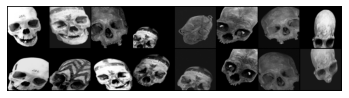

[[0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]


In [109]:
vis_dataloader = DataLoader(pairwise_siamese_dataset,
                        shuffle=True,
                        num_workers=1,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Contrastive loss function

Here we define the contrastive loss.

In [0]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(
            output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + 
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

##Create or load model

You can train the neural network from scratch if you'd like, or alternatively load a pre-existing model.

### Training the neural network

The next three blocks configure all of the variables and settings for training the neural network. You might want to experiment with changing the values of the Adam optimizer.

In [0]:
train_dataloader = DataLoader(
    pairwise_siamese_dataset,
    shuffle=False,
    num_workers=Config.num_generator_workers,
    batch_size=Config.train_batch_size)

In [0]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.00006 )

In [0]:
counter = []
loss_history = [] 
iteration_number= 0

#### Start the training

This next block will start the training for the number of epochs set at the start of the notebook in the configuration block. The code is slightly modified so that filenames get stored for the images.

In [0]:

for epoch in range(0,Config.train_number_iterations):
    for i, data in enumerate(train_dataloader,0):
		# Modifications by Tim Sherrat, to enable path printing
        # Note the underscores! They're the path values, 
        # which we don't actually want here
		# Underscores are used as variable names for things we don't actually 
        # want
        img0, img1 , label, _, _ = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(
                epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

#### Save the model

The block below saves the state dictionary, and the model. This is handy so that once you *have* a trained model, you can return to it if your notebook connection to Colab is broken, or if you have to set the project aside for a while. The second block copies (`cp`) the file to a location on Google drive. You can also download the file to your machine directly by right-clicking the filename in the tray at left (you might need to hit 'refresh' to see it, first).

In [0]:
# Save the model!
torch.save(net.state_dict(),'net_params_new.pkl')
torch.save(net, 'net.h5')

In [0]:
cp net_params.pkl "drive/My Drive/one-shot-test"

### Loading a model

If this is your first time through the notebook, you don't need to worry about this; skip down to **Testing**. If you're returning to the project, make sure
+ that you've got hardware acceleration turned on
+ that you've run all of the code again to import the necessary libraries, and set the various configurations 
  + _including_ the SiameseNetwork class

The block below assumes you've connected Google drive. Alternatively you can upload directly.

In [0]:
# Copy the model back from your drive
!cp "drive/My Drive/one-shot-test/net_params.pkl" net_params.pkl

...then tell the machine to load the model:

In [0]:
# Load the model
net=SiameseNetwork()
net.load_state_dict(torch.load('net_params.pkl'))
dp = nn.DataParallel(net) #https://github.com/pytorch/pytorch/issues/3805

# The incompatiblekeys message might not be an issue - see
# https://gpytorch.readthedocs.io/en/latest/examples/00_Basic_Usage/Saving_and_Loading_Models.html 
# which replicates that incompatiblekeys message without any kind of comment, 
# seems to be hunkydory

## Testing

This block iteratively loads pairs of images with known provenance versus unknown provenance from different subfolders in your testing folder. It then compares the results of these anchor-unknown pairs using euclidean distance. It will print out the images with the dissimilarity distance, as well as printing out the filenames for each pair. You can experiment with printing these results to a file.

Since this code currently outputs all anchor-unknown pairs, the runtime is __O(n^2)__.

In [0]:
#Time code snippet
#https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution
import time
start_time = time.time()

# Init variable representing testing data's directory, 
# see Config section to specify path
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)

# Create the dataset, pairwise_siamese_dataset_anchors, with data from the 
# testing data
# Then, create a generator with pairwise_siamese_dataset-unknowns
pairwise_siamese_dataset_anchors = PairwiseTestingSiameseNetworkDataset(
    imageFolderDataset=folder_dataset_test,
    transform=transforms.Compose([transforms.Resize((100,100)),
                                transforms.ToTensor()]),
    should_invert=False,
    anchor_iter_index=0, 
    anchor_file_identifier='ref-')

test_dataloader = DataLoader(
    pairwise_siamese_dataset_anchors,
    num_workers=Config.num_generator_workers,
    batch_size=1,
    shuffle=False,
    worker_init_fn=worker_init_fn)

generator_anchor_images = iter(test_dataloader)

workers_terminated_outer = np.zeros(Config.num_generator_workers)
# Outer loop searches for anchors
for i in range(len(generator_anchor_images)):

    # Returns a found anchor's index, image, and filepath
    anchor_index,worker_id_outer,anchor_image,_,anchor_filepath,_ = next(
        generator_anchor_images)
    # Stop outer loop if index is out of bounds, no more potential anchors
    if not(0 in workers_terminated_outer):
        break

    if anchor_index.item() < 0:
        np.put(workers_terminated_outer, worker_id_outer, 1)
    else:
        # Create new dataset with a given known anchor's index
        # Then, create a generator with pairwise_siamese_dataset-unknowns
        pairwise_siamese_dataset_unknowns = PairwiseTestingSiameseNetworkDataset2(
            imageFolderDataset=folder_dataset_test,
            transform=transforms.Compose([transforms.Resize((100,100)),
                                          transforms.ToTensor()]),
            should_invert=False,
            anchor_iter_index=anchor_index, 
            anchor_file_identifier='ref-')
      
        compare_dataloader = test_dataloader = DataLoader(
            pairwise_siamese_dataset_unknowns,
            num_workers=Config.num_generator_workers,
            batch_size=1,shuffle=False,
            worker_init_fn=worker_init_fn)
      
        generator_unknown_prov_images = iter(compare_dataloader)

        workers_terminated_inner = np.zeros(Config.num_generator_workers)
        # Inner loop pairs a known anchor with every image of unknown provenance
        for k in range(len(generator_unknown_prov_images)):
            # no_more_unknowns will return -1 if all pairs have been found
            no_more_unknowns,worker_id_inner,_,unknown_prov_image,_,unknown_prov_filepath = (
                next(generator_unknown_prov_images))

            # Stop this inner loop if all anchor-unknown pairs for the current 
            # anchor image are found
            if not(0 in workers_terminated_inner):
                break

            if no_more_unknowns.item() < 0:
                np.put(workers_terminated_inner, worker_id_inner, 1)
            else:
                concatenated = torch.cat((anchor_image,unknown_prov_image),0)

                # Again getting rid of cuda for my Mac
                output1,output2 = net(
                    Variable(anchor_image).cuda(),
                    Variable(unknown_prov_image).cuda())
                # output1,output2 = net(Variable(x0),Variable(x1))
                euclidean_distance = F.pairwise_distance(output1, output2)

                # Show the images:
                imshow(
                    torchvision.utils.make_grid(concatenated),
                    'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

                # Show the paths for the two images
                print('Image 1: {}'.format(anchor_filepath[0])) 
                print('Image 2: {}'.format(unknown_prov_filepath[0]))
                print('Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

print('Finshed all anchor-unknown pair comparisons')
print("--- %s seconds ---" % (time.time() - start_time))

---
# The End

The two code blocks below print out the structure of the neural network, and the version info of all of the loaded packages in this environment. This information is useful for replicating this notebook in the future.


In [0]:
from torchvision import models
model = net
print(model)

In [0]:
# watermark is not installed by default.
# the first time through, uncomment the two lines below
# then run the block.
#
#
# !pip install watermark
# %load_ext watermark
%watermark -v -m -p numpy,scipy,torchvision,PIL,tensorflow,torch -g